In [ ]:
!pip install feature_engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.1/364.1 kB 19.2 MB/s eta 0:00:00


In [ ]:
# Основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

# Настройки и стили
plt.style.use('fast') #выберите единый стиль для ваших графиков
%matplotlib inline
warnings.filterwarnings('ignore')

# Библиотеки для работы со временем
from datetime import datetime, date, time, timedelta
from calendar import monthrange

# Библиотеки для предобработки
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from feature_engine.encoding import MeanEncoder

# Классификаторы
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Рекомендованные регрессоры для физиков
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.svm import SVR

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Задача 1

При каждом обучении модели не забывайте производить подбор гиперпараметров для достижения наилучшей точности. Там, где возможна утечка таргета &mdash; старайтесь использовать `Pipeline`.

Рекомендуется также изучить ячейку с импортами. Возможно, там вы найдёте если не подсказки, то полезные инструменты для работы с данными.

---

Вам предстоит предсказать исход для животных, покидающих Центр животных. Эти исходы включают: Появление новых хозяев, Смерть, Эвтаназию, Возврат владельцу и Передачу (Adoption, Died, Euthanasia, Return to owner, and Transfer).


 Датасет можно найти по следующей ссылке (вам нужна только папка train): [Shelter Animal Outcomes](https://www.kaggle.com/competitions/shelter-animal-outcomes).

##### Основные характеристики животных

- **AnimalID**: уникальный идентификатор животного
- **Name**: имя животного
- **DateTime**: дата и время
- **OutcomeType**: тип исхода (например, Появление новых хозяев, Смерть, Эвтаназия, Возврат владельцу, Передача)
- **OutcomeSubtype**: подтип исхода
- **AnimalType**: тип животного (например, кошка, собака)
- **SexuponOutcome**: пол животного на момент исхода
- **AgeuponOutcome**: возраст животного на момент исхода
- **Breed**: порода животного
- **Color**: цвет животного

**Метрикой в этой задаче является LogLoss !**

 Формула тогда будет следующей:

$$
\text{logloss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{M} y_{ij} \log(p_{ij}),
$$

где:
- \( N \) — количество животных в тестовом наборе,
- \( M \) — количество исходов,
- \( log \) — натуральный логарифм,
- \( y_{ij} \) равно 1, если наблюдение \( i \) принадлежит исходу \( j \), и 0 в противном случае,
- \( p_{ij} \) — предсказанная вероятность того, что наблюдение \( i \) принадлежит исходу \( j \).


In [ ]:
from sklearn.metrics import log_loss

Cкачайте и выведите датасет

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/data/shelter_animal_outcomes.csv", index_col='AnimalID')
df.head()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
AnimalID,,,,,,,,,
A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26729 entries, A671945 to A706629
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Name            19038 non-null  object
 1   DateTime        26729 non-null  object
 2   OutcomeType     26729 non-null  object
 3   OutcomeSubtype  13117 non-null  object
 4   AnimalType      26729 non-null  object
 5   SexuponOutcome  26728 non-null  object
 6   AgeuponOutcome  26711 non-null  object
 7   Breed           26729 non-null  object
 8   Color           26729 non-null  object
dtypes: object(9)
memory usage: 2.0+ MB


Ни одного числового признака! Ситуация осложняется тем, что не все столбцы могут быть "в лоб" преобразованы в числа.

##### 1. Предобработка

Приведём данные к более "рабочему" виду. Сначала преобразуем столбец возраста на момент выхода из приюта (`AgeuponOutcome`):

In [ ]:
def apply_transform_dates(x):
    """
    Считывает строку вида 'N период' и возвращает число дней равное N * (к-во дней в периоде)

    Args:
        x (str): объект

    Returns:
        float: возраст животного в днях
    """
    if pd.isnull(x):
        return x
    num_val = float(x.split(" ")[0])
    if "year" in x.lower():
        return num_val * 365 # примем, что в году 365 дней
    elif "month" in x.lower():
        return num_val * 30 # примем, что в месяце 30 дней
    elif "week" in x.lower():
        return num_val * 7

df["AgeuponOutcome"] = df["AgeuponOutcome"].apply(apply_transform_dates)

Из столбца породы `Breed` выделим два признака: помесь/не помесь и  название породы. О регулярных выражениях (regex) можно почитать в интернете, например [тут](https://habr.com/ru/articles/349860/). Породы, которые встречаются редко, обозначим просто как "Rare".

In [ ]:
# Создание колонки помесь/не помесь
df['Is_Mix'] = df['Breed'].str.contains('Mix', na=False)

# Уберите слово Mix из названий пород, т. к. для него мы выделили отдельный столбец
df['Breed'] = df['Breed'].str.replace('Mix', '', regex=True)

# Убираем лишние символы при помощи regex
df['Breed'] = df['Breed'].str.replace(r'\s*Black\s*|\s*Tan\s*', '', regex=True)
df['Breed'] = df['Breed'].replace('/', '', regex=True)
df['Breed'] = df['Breed'].str.strip('/')
df['Breed'] = df['Breed'].str.split('/').str[0]

Давайте посмотрим на количество уникальных пород

In [ ]:
len(df['Breed'].unique())

1380

In [ ]:
len(df) / len(df['Breed'].unique())

19.368840579710145

Видно что пород крайне много, давайте посмотрим сколько кого встречается, и попробуем оставить только более-менее распространенные породы

In [ ]:
# Очистка редких пород
breed_counts = df['Breed'].value_counts()

freq_breed = len(df) // len(df['Breed'].unique()) # укажите пороговое количество, начиная с которого породу будем считать редкой

common_breeds = breed_counts[breed_counts > freq_breed].index.tolist()
df['Breed'] = df['Breed'].apply(lambda x: 'Rare' if x not in common_breeds else x) # переименнуем породу в редкую

Преобразуйте столбец даты и времени. Можете добавить столбцы года, месяца, дня, часа, дня недели или любое их подмножество. Напоминаем, что библиотека pandas предоставляет для этого удобный функционал.

In [ ]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['Day'] = df['DateTime'].dt.day
df['Hour'] = df['DateTime'].dt.hour

In [ ]:
df.head()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Is_Mix,Year,Month,Day,Hour
AnimalID,,,,,,,,,,,,,,
A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,365.0,Shetland Sheepdog,Brown/White,True,2014,2,12,18
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,365.0,Domestic Shorthair,Cream Tabby,True,2013,10,13,12
A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,730.0,Pit Bull,Blue/White,True,2015,1,31,12
A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,21.0,Domestic Shorthair,Blue Cream,True,2014,7,11,19
A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,730.0,Rare,Tan,False,2013,11,15,12


Преобразуйте столбец пола (`SexuponOutcome`). Обратите внимание: помимо самого пола данный признак содержит информацию о стерилизации. Замените данный признак двумя столбцами:

In [ ]:
sex_data = df['SexuponOutcome'].str.split(' ', n=2, expand=True)

df['Sterilized'] = sex_data[0]
df['Sex'] = sex_data[1]

Также можно не выбрасывать столбец кличек животных. В предсказании целевой переменной может помочь информация о его наличии или отсутствии. Сгенерируйте соответствующий признак:

In [ ]:
def name_exists(name):
    return 1 if pd.notna(name) and name else 0

df['has_name'] = df['Name'].apply(name_exists)

In [ ]:
df.head()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Is_Mix,Year,Month,Day,Hour,Sterilized,Sex,has_name
AnimalID,,,,,,,,,,,,,,,,,
A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,365.0,Shetland Sheepdog,Brown/White,True,2014,2,12,18,Neutered,Male,1
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,365.0,Domestic Shorthair,Cream Tabby,True,2013,10,13,12,Spayed,Female,1
A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,730.0,Pit Bull,Blue/White,True,2015,1,31,12,Neutered,Male,1
A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,21.0,Domestic Shorthair,Blue Cream,True,2014,7,11,19,Intact,Male,0
A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,730.0,Rare,Tan,False,2013,11,15,12,Neutered,Male,0


Обработайте пропуски в данных. Вспомните, какие методы обработки пропусков вы проходили в прошлом семестре. Объясните использование того или иного метода. Если будете удалять строки с пропусками, не забывайте что в столбце `Name` пропуски несут полезную информацию!

In [ ]:
df['OutcomeType'].isna().sum()

0

In [ ]:
df.isna().sum()

,0
Name,7691
DateTime,0
OutcomeType,0
OutcomeSubtype,13612
AnimalType,0
SexuponOutcome,1
AgeuponOutcome,416
Breed,0
Color,0
Is_Mix,0


In [ ]:
df['SexuponOutcome'].describe()

,SexuponOutcome
count,26728
unique,5
top,Neutered Male
freq,9779


In [ ]:
# единственный пропуск в SexuponOutcome заполним самым частым значением (с учетом что у нас теперь два отдельных признака)
df.loc[df['SexuponOutcome'].isna(), 'Sex'] = 'Male'
df.loc[df['SexuponOutcome'].isna(), 'Sterilized'] = 'Neutered'

In [ ]:
# в колонке SexuponOutcome существовало значение Unknown которое перенеслось в Sterilized
# в Sex получились None, заполним их Unknown добавив соответствующий признак, а также вообще все пропуски в этих колонках
df['Sterilized'].fillna('Unknown', inplace=True)
df['Sex'].fillna('Unknown', inplace=True)

In [ ]:
# для Name мы создали отдельный признак, OutcomeSubtype мы дропаем, остается возраст который просто возьмем среднее для отсутствующих
df['AgeuponOutcome'].fillna(df['AgeuponOutcome'].dropna().mean(), inplace=True)

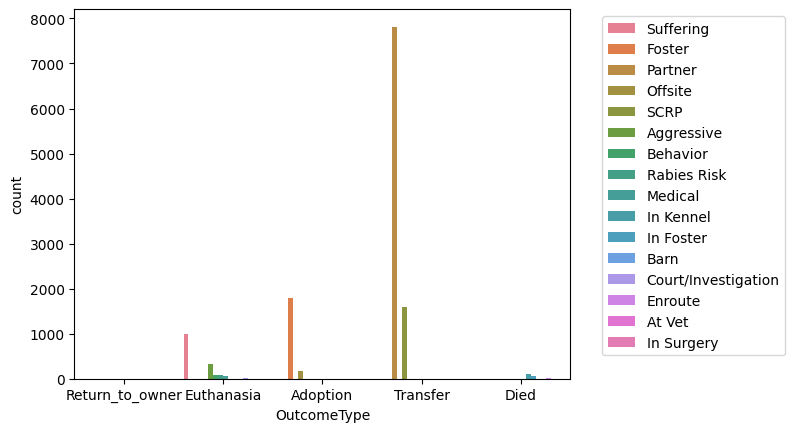

In [ ]:
# OutcomeSubtype ощущается как рандомный признак, слишком тесно связан с таргетом (например 80% соответствие Transfer-Partner)
# думаю его предполагается дропнуть (или это большая ошибка...)
sns.countplot(data=df, x='OutcomeType', hue='OutcomeSubtype', legend='brief')
plt.legend(bbox_to_anchor=(1.05, 1))

In [ ]:
df.isna().sum()

,0
Name,7691
DateTime,0
OutcomeType,0
OutcomeSubtype,13612
AnimalType,0
SexuponOutcome,1
AgeuponOutcome,0
Breed,0
Color,0
Is_Mix,0


<Axes: xlabel='OutcomeType', ylabel='Count'>

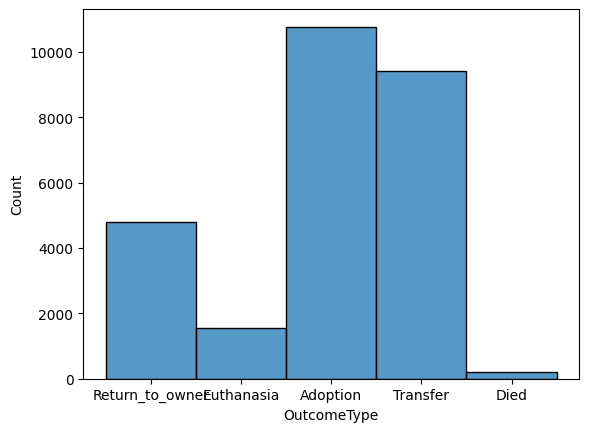

In [ ]:
sns.histplot(df['OutcomeType'], palette='Set3')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26729 entries, A671945 to A706629
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Name            19038 non-null  object        
 1   DateTime        26729 non-null  datetime64[ns]
 2   OutcomeType     26729 non-null  object        
 3   OutcomeSubtype  13117 non-null  object        
 4   AnimalType      26729 non-null  object        
 5   SexuponOutcome  26728 non-null  object        
 6   AgeuponOutcome  26729 non-null  float64       
 7   Breed           26729 non-null  object        
 8   Color           26729 non-null  object        
 9   Is_Mix          26729 non-null  bool          
 10  Year            26729 non-null  int32         
 11  Month           26729 non-null  int32         
 12  Day             26729 non-null  int32         
 13  Hour            26729 non-null  int32         
 14  Sterilized      26729 non-null  object        
 15 

In [ ]:
#преобразуем отдельно колонку цветов, иначе слишком много разнообразных значений
def color_group(color):
  try:
    color_type = color.split()
  except:
    return "unknown"
  return str(color_type[0])
color_group('Brown/White')
df["Color"] = df["Color"].apply(color_group)

Кажется... готово! Впрочем, если есть желание и светлые идеи как модернизировать предложенную предобработку данных, их воплощение только приветствуется. Главное &mdash; не забывайте писать пояснения!

##### 2. Кодирование категориальных признаков

А мы перейдём к кодированию категориальных признаков. Напомним подходящие методы: OneHotEncoding &mdash; для малого количества неупорядоченных меток, LabelEncoding &mdash; для упорядоченных меток, MeanEncoding &mdash;  большое количество неупорядоченных меток классов. Также в лекции упоминались Binary- и FrequencyEncoding. В случае, если возможна утечка таргета, напишите пояснение что вы собираетесь использовать для каждого столбца, а сам метод применяйте уже внутри пайплайна при подборе гиперпараметров. Столбцы, которые не собираетесь использовать &mdash; удалите.

In [ ]:
df_clean = df.drop(columns=['OutcomeSubtype', 'OutcomeType', 'SexuponOutcome', 'Name', 'DateTime'])

In [ ]:
df_clean.head()

,AnimalType,AgeuponOutcome,Breed,Color,Is_Mix,Year,Month,Day,Hour,Sterilized,Sex,has_name
AnimalID,,,,,,,,,,,,
A671945,Dog,365.0,Shetland Sheepdog,Brown/White,True,2014,2,12,18,Neutered,Male,1
A656520,Cat,365.0,Domestic Shorthair,Cream,True,2013,10,13,12,Spayed,Female,1
A686464,Dog,730.0,Pit Bull,Blue/White,True,2015,1,31,12,Neutered,Male,1
A683430,Cat,21.0,Domestic Shorthair,Blue,True,2014,7,11,19,Intact,Male,0
A667013,Dog,730.0,Rare,Tan,False,2013,11,15,12,Neutered,Male,0


In [ ]:
# будем применять методы внутри пайплайна, ниже - мотивация
# One Hot Encoder для is_mix, animal type, sterilized, sex - это всё неупорядоченные признаки с не больше чем тремя уникальными значениями
# Mean Encoding для Color, Breed неупорядоченные метки с очень большим разнообразием значений
# для таргетов будем применять лайбл энкодинг (что не хорошо потому что признаки не упорядочены) потому что я не придумала ничего лучше
y = df['OutcomeType']
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)


In [ ]:
# numeric_columns = df.select_dtypes(include=[np.number, 'boolean']).columns.tolist()

# numeric_columns.append('OutcomeType')

# selected_df = df[numeric_columns]
# selected_df.head()

##### 3. Обучение модели на датасете с закодированными признаками

Выберите и зафиксируйте семейство моделей, с которым будете проводить дальнейшие эксперименты. Используйте *интерпретируемую* модель &mdash; например, линейную регрессию с регуляризацией или решающее дерево. Это в дальнейшем нам пригодится.

В каждом эксперименте проводите подбор наилучшей модели путём подбора гиперпараметров. Во избежание утечки таргета используйте `sklearn.Pipeline`.

Для начала обучите модель на получившемся датасете.

In [ ]:
X = df_clean

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=30, stratify=y
)

In [ ]:
numeric_features = ["AgeuponOutcome", "Year", "Month", 'Day', 'Hour', 'has_name']
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_features = ["AnimalType", 'Is_Mix', 'Sterilized', 'Sex']
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder()),
    ]
)

categorical_features_2 = ["Breed", "Color"]
categorical_transformer_2 = Pipeline(
    steps=[
        ("encoder_2", MeanEncoder()),
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("cat_2", categorical_transformer_2, categorical_features_2)
    ]
)

In [ ]:
steps = [
    ("preprocessor", preprocessor),
    ('imputer', SimpleImputer(strategy='mean')),
    ("scaler", StandardScaler()),
    ('clf', LogisticRegression(solver='saga',
                               multi_class='multinomial',
                               max_iter=5000))
]

pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
prediction = pipeline.predict_proba(X_test)
accuracy = log_loss(y_true=y_test, y_pred=prediction)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.881


In [ ]:
#hyperparams
parameteres = {'clf__penalty': ['l1', 'l2'],
               'clf__C': [0.01, 0.1, 1, 10]}

grid = GridSearchCV(
    pipeline, param_grid=parameteres, cv=5, scoring='neg_log_loss'
)

grid.fit(X_train, y_train)

print(f"Accuracy = {grid.score(X_test, y_test):.2f}")
print(grid.best_params_)


Accuracy = -0.88
{'clf__C': 0.1, 'clf__penalty': 'l1'}


In [ ]:
#параметр scoring neg_log_loss отсюда получаем минус видимо

##### 3. Feature engineering
Сгенерируйте новые признаки. Например, на основе даты и времени или возраста животных. Ниже приведён пример того как можно отобразить суммарную частоту смертельных исходов и эвтаназии по месяцам. На его основе вы можете посмотреть на аналогичные статистики за другой промежуток времени, по другим исходам или вообще по другим столбцам. Вдруг это поможет сгенерировать новые осмысленные признаки, связанные с выявленной периодичностью или чем-то ещё.

Также, возможно, более тщательное изучение описания датасета, понимание смысла тех или иных признаков, натолкнёт вас на другие идеи.

In [ ]:
# Переводим в формат даты-времени
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Задаём периодичность
freq_type = "M" # укажите тут любую другую частоту

# Выделение смертельных исходов связанных с эвтаназией и с иными причинами
death_outcomes      = df[["DateTime", "OutcomeType"]].loc[(df['OutcomeType'] == 'Died')]
euthanasia_outcomes = df[["DateTime", "OutcomeType"]].loc[(df['OutcomeType'] == 'Euthanasia')]

# Группировка соответствующих подтаблиц по месяцам. Описание объекта `pd.Grouper` см. в замечании ниже
death_frequency_per_month = death_outcomes.groupby(pd.Grouper(key='DateTime', freq=freq_type)).value_counts()
euthanasia_frequency_per_month = euthanasia_outcomes.groupby(pd.Grouper(key='DateTime', freq=freq_type)).value_counts()

# Хотим сложить два исхода по соответствующим индексам.
# Но индексы в даннном случае представляют собой объекты pd.MultiIndex вида ('DateTime', 'Death') или ('DateTime', 'Euthanasia')
# Для сложения строк с одинаковыми датами нам нужны обычные индексы типа 'DateTime'. Сделаем это:
death_frequency_per_month.index = death_frequency_per_month.index.get_level_values('DateTime')
euthanasia_frequency_per_month.index = euthanasia_frequency_per_month.index.get_level_values('DateTime')

# Наконец складываем 2 объекта pd.Series
all_death_cases_per_month = death_frequency_per_month + euthanasia_frequency_per_month

# Можете убедиться, что всё корректно:
print('Первые две строки 1-го слагаемого\n', death_frequency_per_month[0:2], '\n')
print('Первые две строки 2-го слагаемого\n', euthanasia_frequency_per_month[0:2], '\n')
print('Первые две строки суммы\n', all_death_cases_per_month[0:2], '\n')


Первые две строки 1-го слагаемого
 DateTime
2013-10-31    12
2013-11-30     3
Name: count, dtype: int64 

Первые две строки 2-го слагаемого
 DateTime
2013-10-31    73
2013-11-30    49
Name: count, dtype: int64 

Первые две строки суммы
 DateTime
2013-10-31    85
2013-11-30    52
Name: count, dtype: int64 



*Замечание.* Метод `pd.Grouper` в библиотеке pandas используется для группировки данных по определенному ключу и частоте. Это особенно полезно для временных рядов, где необходимо агрегировать данные по определенным временным интервалам.

Основные параметры
1. `key`: Строка или объект, указывающий, по какому столбцу или индексу
группировать данные.
2. `freq`: Строка, указывающая частоту группировки. Поддерживаются различные частоты, такие как минуты, часы, дни, месяцы и т.д.

Поддерживаемые частоты (`freq`)
* T: Минуты
* H: Часы
* D: Дни
* W: Недели
* M: Месяцы
* Q: Кварталы
* A: Годы

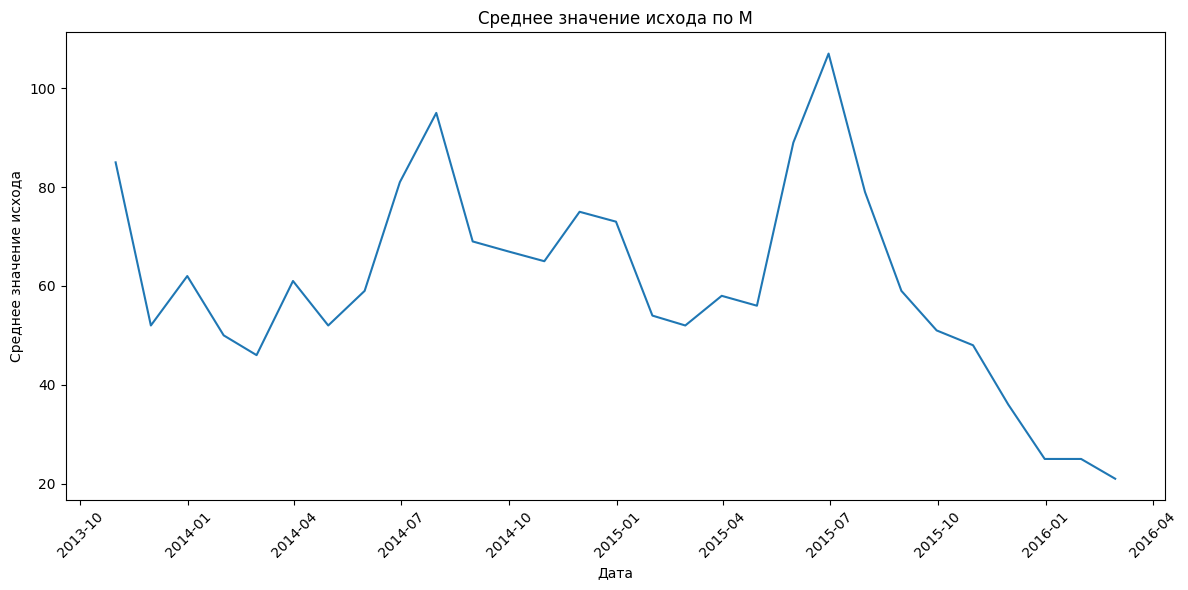

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(all_death_cases_per_month)
plt.title('Среднее значение исхода по ' + str(freq_type))
plt.xlabel('Дата')
plt.ylabel('Среднее значение исхода')
plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
# предполагаем что на взятие из приюта влияют стерилизованность/не (такой признак уже есть из One Hot Encoding), молодость,
# также можно отдельно создать на основе цвета признак для многоцветных особей

In [ ]:
df_clean['Multiple_Colors'] = df_clean['Color'].apply(lambda x : 1 if '/' in x else 0)


In [ ]:
def calc_age_category(x):
    if x < 3*365: return 'baby'
    if x < 5*365: return 'adult'
    return 'old'
df_clean['Age_Range'] = df['AgeuponOutcome'].apply(calc_age_category)

##### 4. Обучение модели на датасете с дополнительными признаками
Проведите эксперимент

In [ ]:
X = df_clean
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=30, stratify=y
)


In [ ]:
numeric_features = ["AgeuponOutcome", "Year", "Month", 'Day', 'Hour', 'has_name', 'Multiple_Colors']
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_features = ["AnimalType", 'Is_Mix', 'Sterilized', 'Sex', 'Age_Range']
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(sparse_output=False)),
    ]
)

categorical_features_2 = ["Breed", "Color"]
categorical_transformer_2 = Pipeline(
    steps=[
        ("encoder_2", MeanEncoder()),
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("cat_2", categorical_transformer_2, categorical_features_2)
    ]
)

In [ ]:
steps = [
    ("preprocessor", preprocessor),
    ('imputer', SimpleImputer(strategy='mean')),
    ("scaler", StandardScaler()),
    ('clf', LogisticRegression(solver='saga',
                               multi_class='multinomial',
                               max_iter=5000))
]

pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
prediction = pipeline.predict_proba(X_test)
accuracy = log_loss(y_true=y_test, y_pred=prediction)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.877


In [ ]:
# steps = [
#     ("preprocessor", preprocessor),
#     ('imputer', SimpleImputer(strategy='mean')),
#     ("scaler", StandardScaler()),
#     ('clf', DecisionTreeClassifier())
# ]

# pipeline = Pipeline(steps)
# pipeline.fit(X_train, y_train)
# prediction = pipeline.predict_proba(X_test)
# accuracy = log_loss(y_true=y_test, y_pred=prediction)
# print(f'Accuracy: {accuracy:.3f}')


In [ ]:
#hyperparams
parameteres = {'clf__penalty': ['l1', 'l2'],
               'clf__C': [0.01, 0.1, 1, 10]}

grid = GridSearchCV(
    pipeline, param_grid=parameteres, cv=5, scoring='neg_log_loss'
)

grid.fit(X_train, y_train)

print(f"Accuracy = {grid.score(X_test, y_test):.3f}")
print(grid.best_params_)


Accuracy = -0.877
{'clf__C': 0.1, 'clf__penalty': 'l1'}


##### 5. Отбор признаков

На лекции было рассказано о нескольких методах отбора признаков. Воспользуйтесь одним или несколькими из них, отберите наиболее важные признаки. Удобно отображать важность признаков при помощи гистограмм. Вновь произведите обучение и сравните полученные результаты с прошлыми экспериментами.

In [ ]:
numeric_features = pipeline.named_steps['preprocessor'].transformers_[0][2]
categorical_features = pipeline.named_steps['preprocessor'].transformers_[1][2]
categorical_features_2 = pipeline.named_steps['preprocessor'].transformers_[2][2]

feature_names_after_encoding = list(pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_features))

mean_encoder_column_name = list(pipeline.named_steps['preprocessor'].transformers_[2][1].named_steps['encoder_2'].get_feature_names_out(categorical_features_2))

feature_names = numeric_features + feature_names_after_encoding + mean_encoder_column_name
feature_importance = pipeline.named_steps['clf'].coef_

for class_index, class_importance in enumerate(feature_importance):
  print(f"\nFeature Importance for Class {class_index}:\n")
  for i, importance in enumerate(class_importance):
    print(f"Feature: {feature_names[i]}, Importance: {importance:.3f}")



Feature Importance for Class 0:

Feature: AgeuponOutcome, Importance: -0.730
Feature: Year, Importance: 0.084
Feature: Month, Importance: 0.033
Feature: Day, Importance: 0.046
Feature: Hour, Importance: 0.429
Feature: has_name, Importance: 0.109
Feature: Multiple_Colors, Importance: -0.054
Feature: AnimalType_Cat, Importance: 0.128
Feature: AnimalType_Dog, Importance: -0.128
Feature: Is_Mix_False, Importance: 0.005
Feature: Is_Mix_True, Importance: -0.005
Feature: Sterilized_Intact, Importance: -0.814
Feature: Sterilized_Neutered, Importance: 0.569
Feature: Sterilized_Spayed, Importance: 0.436
Feature: Sterilized_Unknown, Importance: -0.608
Feature: Sex_Female, Importance: 0.223
Feature: Sex_Male, Importance: 0.018
Feature: Sex_Unknown, Importance: -0.608
Feature: Age_Range_adult, Importance: -0.085
Feature: Age_Range_baby, Importance: -0.041
Feature: Age_Range_old, Importance: 0.123
Feature: Breed, Importance: -0.208
Feature: Color, Importance: -0.124

Feature Importance for Class 1:

In [ ]:
features_all = [
    "AgeuponOutcome",
    "Year",
    "Month",
    "Day",
    "Hour",
    "has_name",
    "Multiple_Colors",
    "AnimalType_Cat",
    "AnimalType_Dog",
    "Is_Mix_False",
    "Is_Mix_True",
    "Sterilized_Intact",
    "Sterilized_Neutered",
    "Sterilized_Spayed",
    "Sterilized_Unknown",
    "Sex_Female",
    "Sex_Male",
    "Sex_Unknown",
    "Age_Range_adult",
    "Age_Range_baby",
    "Age_Range_old",
    "Breed",
    "Color"
]



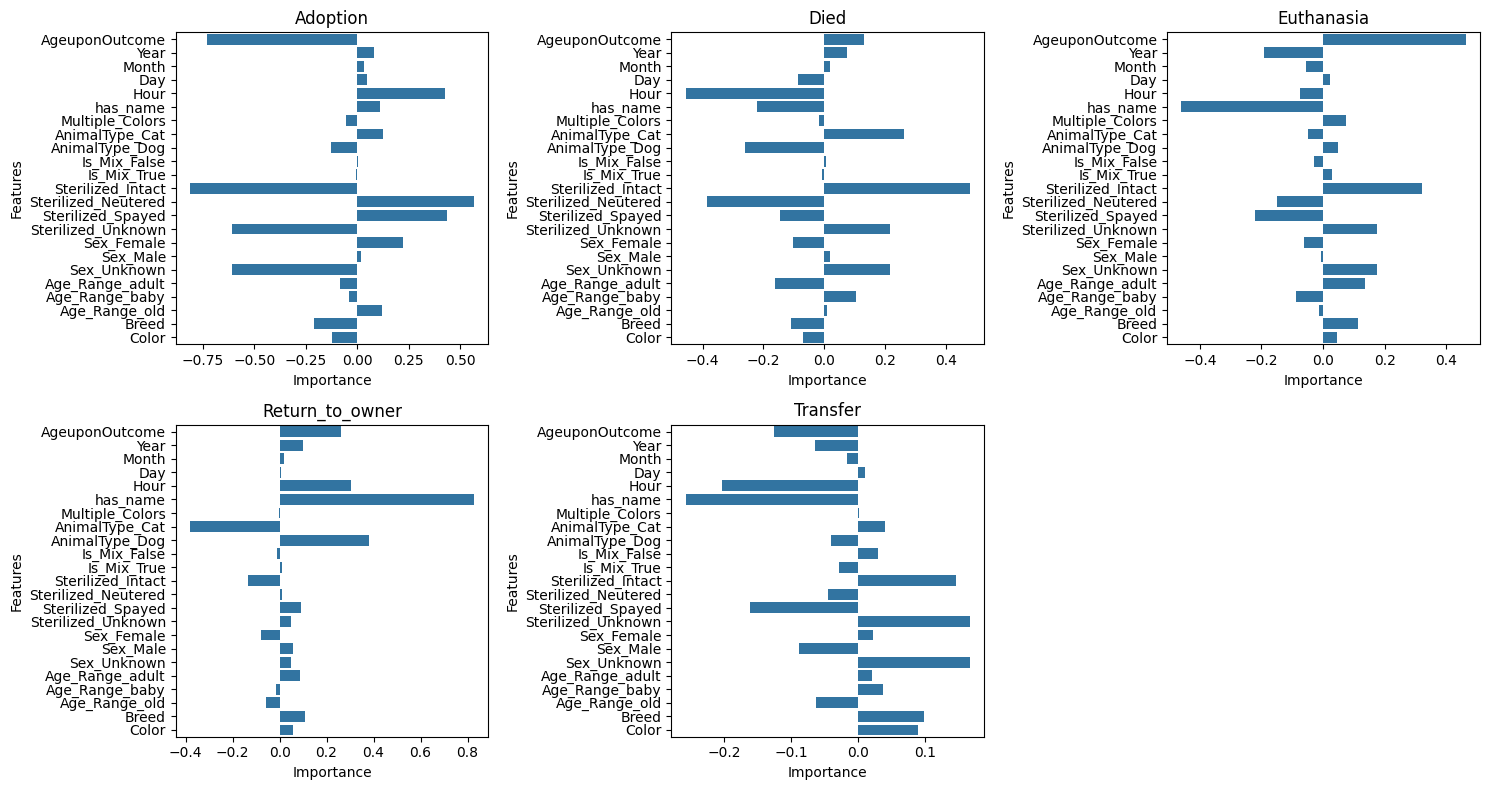

In [ ]:
num_classes = len(feature_importance)

class_names = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']

num_rows = 2
num_cols = (num_classes + 1) // num_rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

for i in range(num_classes):
    row = i // num_cols
    col = i % num_cols
    sns.barplot(y=features_all, x=feature_importance[i], ax=axes[row, col])
    axes[row, col].set_title(class_names[i])
    axes[row, col].set_xlabel('Importance')
    axes[row, col].set_ylabel('Features')

for j in range(num_classes, num_rows * num_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


In [ ]:
X= transformed_df
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=30, stratify=y_enc
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=30, stratify=y_train_val
)


In [ ]:
steps = [
    ("preprocessor", preprocessor),
    ('imputer', SimpleImputer(strategy='mean')),
    ("scaler", StandardScaler()),
    ('clf', LogisticRegression(solver='saga',
                               multi_class='multinomial',
                               max_iter=5000))
]

pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
prediction = pipeline.predict_proba(X_test)
accuracy = log_loss(y_true=y_test, y_pred=prediction)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.878


In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
numeric_features = pipeline.named_steps['preprocessor'].transformers_[0][2]
categorical_features = pipeline.named_steps['preprocessor'].transformers_[1][2]
categorical_features_2 = pipeline.named_steps['preprocessor'].transformers_[2][2]

feature_names_after_encoding = list(pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_features))
mean_encoder_column_name = list(pipeline.named_steps['preprocessor'].transformers_[2][1].named_steps['encoder_2'].get_feature_names_out(categorical_features_2))

feature_names = numeric_features + feature_names_after_encoding + mean_encoder_column_name

prediction = pipeline.predict_proba(X_test)
accuracy = log_loss(y_true=y_test, y_pred=prediction)
print(f'Accuracy: {accuracy:.3f}')

result = permutation_importance(
  pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

print("\nImportant Features:")
for i in result.importances_mean.argsort()[::-1]:
  if np.abs(result.importances_mean[i] - 2 * result.importances_std[i]) > 0:
    print(f"{feature_names[i]}: {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")


Accuracy: 0.878

Important Features:
Is_Mix_False: 0.158 +/- 0.004
Year: 0.058 +/- 0.003
AnimalType_Dog: 0.019 +/- 0.002
Sterilized_Intact: 0.018 +/- 0.003
AgeuponOutcome: 0.017 +/- 0.003
Is_Mix_True: 0.012 +/- 0.003
Hour: 0.002 +/- 0.001


In [ ]:
numeric_features = pipeline.named_steps['preprocessor'].transformers_[0][2]
categorical_features = pipeline.named_steps['preprocessor'].transformers_[1][2]
categorical_features_2 = pipeline.named_steps['preprocessor'].transformers_[2][2]

feature_names_after_encoding = list(pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_features))
mean_encoder_column_name = list(pipeline.named_steps['preprocessor'].transformers_[2][1].named_steps['encoder_2'].get_feature_names_out(categorical_features_2))

feature_names = numeric_features + feature_names_after_encoding + mean_encoder_column_name

prediction = pipeline.predict_proba(X_test)
accuracy = log_loss(y_true=y_test, y_pred=prediction)
print(f'Accuracy: {accuracy:.3f}')

result = permutation_importance(
  pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

print("\nImportant Features:")
for i in result.importances_mean.argsort()[::-1]:
  if np.abs(result.importances_mean[i] - 2 * result.importances_std[i]) > 0:
    print(f"{feature_names[i]}: {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")


Accuracy: 0.878

Important Features:
Is_Mix_False: 0.158 +/- 0.004
Year: 0.058 +/- 0.003
AnimalType_Dog: 0.019 +/- 0.002
Sterilized_Intact: 0.018 +/- 0.003
AgeuponOutcome: 0.017 +/- 0.003
Is_Mix_True: 0.012 +/- 0.003
Hour: 0.002 +/- 0.001
has_name: 0.001 +/- 0.001
Day: -0.001 +/- 0.002
Month: -0.001 +/- 0.002
Sterilized_Neutered: -0.002 +/- 0.001
Multiple_Colors: -0.002 +/- 0.001
AnimalType_Cat: -0.003 +/- 0.001
Sterilized_Spayed: -0.005 +/- 0.001


In [ ]:
features_selected = [
    "remainder__onehot__Is_Mix_False",
    "scaler__remainder__Year",
    "remainder__onehot__AnimalType_Dog",
    "remainder__onehot__Sterilized_Intact",
    "scaler__remainder__AgeuponOutcome",
    "remainder__onehot__Is_Mix_True",
    "scaler__remainder__Hour",
    "scaler__remainder__has_name",
    "scaler__remainder__Day",
    "scaler__remainder__Month",
    "remainder__onehot__Sterilized_Neutered",
    "scaler__remainder__Multiple_Colors",
    "remainder__onehot__AnimalType_Cat",
    "remainder__onehot__Sterilized_Spayed"
]


In [ ]:
chosen_columns = ["remainder__AgeuponOutcome", "remainder__Year", "remainder__Month", 'remainder__Day', 'remainder__Hour', 'remainder__has_name', 'remainder__Multiple_Colors']
transformer = ColumnTransformer(
  transformers=[
    ('scaler', StandardScaler(), chosen_columns)
  ],
  remainder='passthrough'
)

transformed_df = transformer.fit_transform(transformed_df)

transformed_df = pd.DataFrame(transformed_df, columns=transformer.get_feature_names_out())
transformed_df

In [ ]:
transformed_df

,scaler__remainder__AgeuponOutcome,scaler__remainder__Year,scaler__remainder__Month,scaler__remainder__Day,scaler__remainder__Hour,scaler__remainder__has_name,scaler__remainder__Multiple_Colors,remainder__onehot__AnimalType_Cat,remainder__onehot__AnimalType_Dog,remainder__onehot__Is_Mix_False,...,remainder__onehot__Sterilized_Spayed,remainder__onehot__Sterilized_Unknown,remainder__onehot__Sex_Female,remainder__onehot__Sex_Male,remainder__onehot__Sex_Unknown,remainder__onehot__Age_Range_adult,remainder__onehot__Age_Range_baby,remainder__onehot__Age_Range_old,remainder__remainder__Breed,remainder__remainder__Color
0,-0.409155,-0.580974,-1.409043,-0.421688,1.065124,0.635595,1.169578,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Shetland Sheepdog,Brown/White
1,-0.409155,-1.929785,0.879415,-0.307667,-0.732754,0.635595,-0.855009,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,Domestic Shorthair,Cream
2,-0.070586,0.767836,-1.6951,1.744707,-0.732754,0.635595,1.169578,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Pit Bull,Blue/White
3,-0.728245,-0.580974,0.021244,-0.535709,1.36477,-1.573328,-0.855009,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Domestic Shorthair,Blue
4,-0.070586,-1.929785,1.165473,-0.079626,-0.732754,-1.573328,-0.855009,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Rare,Tan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26724,-0.719896,0.767836,-0.550871,-0.193646,-1.0324,-1.573328,-0.855009,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Domestic Shorthair,Brown
26725,-0.664241,2.116647,-1.6951,0.490478,1.065124,-1.573328,-0.855009,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,Domestic Shorthair,Brown
26726,0.606552,0.767836,-1.122985,-0.76375,-0.433108,0.635595,1.169578,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,Rare,White/Tan
26727,-0.721752,-0.580974,-0.836928,1.288624,-0.732754,-1.573328,-0.855009,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Domestic Shorthair,Black


In [ ]:
steps = [
    ("preprocessor", preprocessor),
    ('imputer', SimpleImputer(strategy='mean')),
    ("scaler", StandardScaler()),
    ('clf', LogisticRegression(solver='saga',
                               multi_class='multinomial',
                               max_iter=5000))
]

pipeline = Pipeline(steps)
pipeline.fit(X_train['scaler__remainder__AgeuponOutcome', 'scaler__remainder__Year',
       'scaler__remainder__Month', 'scaler__remainder__Day',
       'scaler__remainder__Hour', 'scaler__remainder__has_name',
       'scaler__remainder__Multiple_Colors',
       'remainder__onehot__AnimalType_Cat',
       'remainder__onehot__AnimalType_Dog', 'remainder__onehot__Is_Mix_False',
       'remainder__onehot__Is_Mix_True',
       'remainder__onehot__Sterilized_Intact',
       'remainder__onehot__Sterilized_Neutered',
       'remainder__onehot__Sterilized_Spayed',
       'remainder__onehot__Sex_Female', 'remainder__onehot__Sex_Male',
       'remainder__onehot__Sex_Unknown'], y_train)
prediction = pipeline.predict_proba(X_test)
accuracy = log_loss(y_true=y_test, y_pred=prediction)
print(f'Accuracy: {accuracy:.3f}')

KeyError: ('scaler__remainder__AgeuponOutcome', 'scaler__remainder__Year', 'scaler__remainder__Month', 'scaler__remainder__Day', 'scaler__remainder__Hour', 'scaler__remainder__has_name', 'scaler__remainder__Multiple_Colors', 'remainder__onehot__AnimalType_Cat', 'remainder__onehot__AnimalType_Dog', 'remainder__onehot__Is_Mix_False', 'remainder__onehot__Is_Mix_True', 'remainder__onehot__Sterilized_Intact', 'remainder__onehot__Sterilized_Neutered', 'remainder__onehot__Sterilized_Spayed', 'remainder__onehot__Sex_Female', 'remainder__onehot__Sex_Male', 'remainder__onehot__Sex_Unknown')

In [ ]:
X_train.columns

Index(['scaler__remainder__AgeuponOutcome', 'scaler__remainder__Year',
       'scaler__remainder__Month', 'scaler__remainder__Day',
       'scaler__remainder__Hour', 'scaler__remainder__has_name',
       'scaler__remainder__Multiple_Colors',
       'remainder__onehot__AnimalType_Cat',
       'remainder__onehot__AnimalType_Dog', 'remainder__onehot__Is_Mix_False',
       'remainder__onehot__Is_Mix_True',
       'remainder__onehot__Sterilized_Intact',
       'remainder__onehot__Sterilized_Neutered',
       'remainder__onehot__Sterilized_Spayed',
       'remainder__onehot__Sterilized_Unknown',
       'remainder__onehot__Sex_Female', 'remainder__onehot__Sex_Male',
       'remainder__onehot__Sex_Unknown', 'remainder__onehot__Age_Range_adult',
       'remainder__onehot__Age_Range_baby', 'remainder__onehot__Age_Range_old',
       'remainder__remainder__Breed', 'remainder__remainder__Color'],
      dtype='object')

##### 6. Анализ зависимостей

Выберите эксперимент с наилучшими результатами. Теперь вам необходимо попробовать посмотреть на саму модель. Выведите и проанализируйте коэффициенты, если это линейная модель; если это решающее дерево, то визуализируйте его структуру и посмотрите на узлы. Попробуйте что-то понять о данных и о зависимости признаков и таргета исходя из наилучшей модели. Оцениваются хорошая визуализация и выводы.

##### 6. Сделайте общий вывод

feature engineering в пункте 3 улучшает немного скор, добавили какие-то зависимости которые модель не видела, видно, что важен правильный препроцессинг, например в том числе выбор способа энкодинга (например, не one hot для признаков таких как порода и цвета которые очень раздуют датасет), а также фильтрация редких пород, генерализация цветов от частного к общему.
в пункте 5 отбор признаков снова слегка улучшает скор.
С точки зрения качественного вывода по данным, можно сказать что стерелизованных/кастрированных животных берут больше, также молодых